In [1]:
from qcodes.instrument_drivers.stanford_research.SR830 import SR830
from qcodes.instrument_drivers.Keithley.Keithley_2400 import Keithley2400
from qcodes.instrument_drivers.QuantumDesign import DynaCool

import numpy as np
import qcodes as qc
import pandas
import matplotlib.pyplot as plt
import time

## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)

## Using interactive widget
from qcodes.interactive_widget import experiments_widget
import time
import os
from qcodes.parameters import ElapsedTimeParameter, Parameter

In [2]:
import pyvisa

rm = pyvisa.ResourceManager()
rm.list_resources()

('GPIB0::8::INSTR',)

In [3]:
# Initialize/Choose database
initialise_or_create_database_at("Thesis_PV.db")

In [4]:
#smu = Keithley2400("smu", "GPIB::24::INSTR")
#smu.output(1)

In [5]:
lia1 = SR830("lia1", "GPIB::8::INSTR")
temp_controller = rm.open_resource("GPIB0::1::INSTR")
#smu = Keithley2400("smu", "keith addr")

Connected to: Stanford_Research_Systems SR830 (serial:s/n70447, firmware:ver1.07) in 0.12s


c:\users\matth\appdata\local\programs\python\python38\lib\site-packages\qcodes\instrument\instrument_base.py:143: QCoDeSDeprecationWarning: Parameter ch1_databuffer on instrument lia1 does not correctly pass kwargs to its baseclass. A Parameter class must take `**kwargs` and forward them to its baseclass.
  warnings.warn(
c:\users\matth\appdata\local\programs\python\python38\lib\site-packages\qcodes\instrument\instrument_base.py:143: QCoDeSDeprecationWarning: Parameter ch2_databuffer on instrument lia1 does not correctly pass kwargs to its baseclass. A Parameter class must take `**kwargs` and forward them to its baseclass.
  warnings.warn(


In [6]:
# Create Station and add instruments
station = qc.Station()
station.add_component(lia1)
#station.add_component
#station.add_component(smu)


'lia1'

In [7]:
exp = load_or_create_experiment(
    experiment_name = "Polarization Dependence",
    sample_name= "Sample 1"
)

context_meas = Measurement(exp = exp, station=station, name = "PV Measurement")

In [8]:
context_meas.register_parameter(lia1.X)
context_meas.register_parameter(lia1.Y)
context_meas.register_parameter(lia1.R)
context_meas.register_parameter(lia1.phase)
context_meas.register_parameter(lia1.sensitivity)
context_meas.register_parameter(lia1.amplitude)
#context_meas.register_parameter(smu.volt)
#context_meas.register_parameter(smu.curr)
#set_volt = Parameter('set_volt', label = 'set_volt', unit = 'V', get_cmd = lambda: float(smu.volt.get()))
#context_meas.register_parameter(set_volt)

temp = Parameter('temp', label = 'temp', unit = 'K', get_cmd = lambda: float(temp_controller.read().split()[0]))
context_meas.register_parameter(temp)

curr_time = Parameter('curr_time', label = 'time', unit = 's', get_cmd = lambda: float(time.time()))
context_meas.register_parameter(curr_time)

In [9]:
temp()

121.6

In [10]:
#smu.rangev(.2)
#smu.rangev()

In [11]:
lia1.amplitude()

0.114

In [12]:
def measureAll(datasaver, sleep_time = .1, log = True):
    time.sleep(sleep_time)
    X1, Y1, R1, phase1 = lia1.snap('x', 'y', 'r', 'phase') # add more lock ins here
    temperature = temp.get()
    sensitivity_lia_1 = lia1.sensitivity()
    c_time = time.time()
    amplitude = lia1.amplitude()

    if log == True:
        datasaver.add_result((lia1.X, X1),
                             (lia1.Y, Y1),
                             (lia1.phase, phase1),
                             (lia1.R, R1),
                             (lia1.amplitude, amplitude),

                             (temp, temperature),
                
                             (curr_time, c_time),
                             (lia1.sensitivity, sensitivity_lia_1))
                        
    time.sleep(.1)
    return [X1, Y1, temperature]
    

In [13]:
def IV_Sweep(start = 1e-5, stop = 1, num_steps = 200):
    start = np.log10(start)
    stop = np.log10(stop)
    print(start, stop)
    smu.output(1)
    with context_meas.run() as datasaver:
        set_volt_arr = list(np.logspace(start, stop, num_steps)) + list(np.logspace(stop, start, num_steps))
        smu.compliancei.set(1e-3)
        for set_volt in set_volt_arr:
            smu.volt(set_volt)
            #print(smu.volt())
            c_time = time.time()
            #print(set_volt)
            datasaver.add_result((smu.volt, smu.volt()),
                                 (smu.curr, smu.curr()),
                                (curr_time, c_time))
            time.sleep(.05)

In [16]:
smu.volt(1e-4)
smu.volt()

NameError: name 'smu' is not defined

In [85]:
smu.volt(5e-6)
smu.volt()

5e-06

In [114]:
IV_Sweep(start = 5e-6, stop = 1e-3, num_steps = 100)

-5.301029995663981 -3.0
Starting experimental run with id: 75. 


In [37]:
time_rn = time.time()
with context_meas.run() as datasaver:
    lia1.amplitude(.1)
    while (time.time()-time_rn)<180:
        
        time.sleep(.1)
        measureAll(datasaver)

Starting experimental run with id: 146. 


In [ ]:
# initialise_or_create_database_at("Thesis_PV.db")
def loader(id):
    data = load_by_run_spec(experiment_name = "PV Measurements", captured_run_id = id)
    df = data.to_pandas_dataframe()
    return df

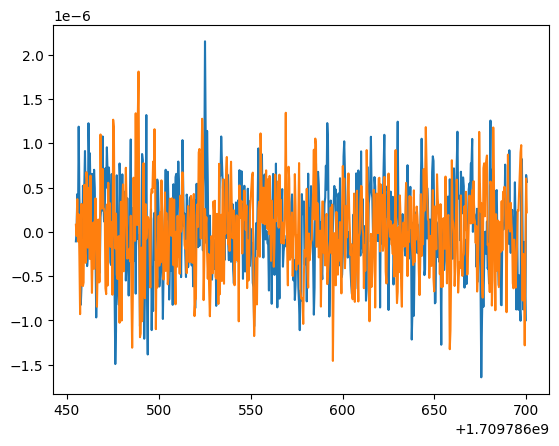

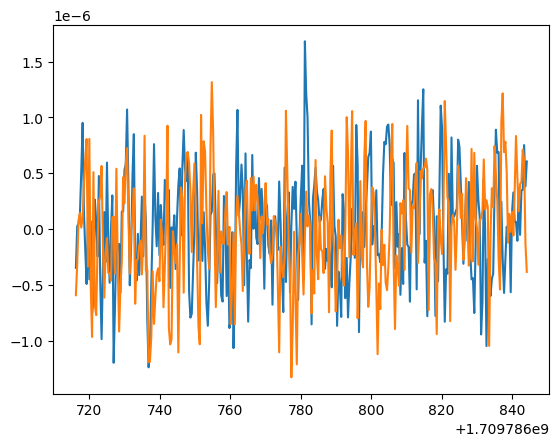

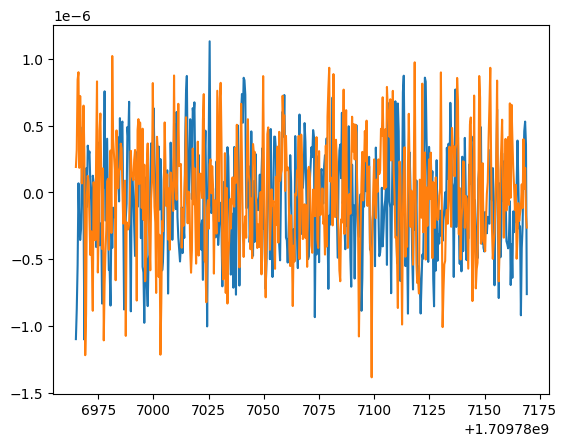

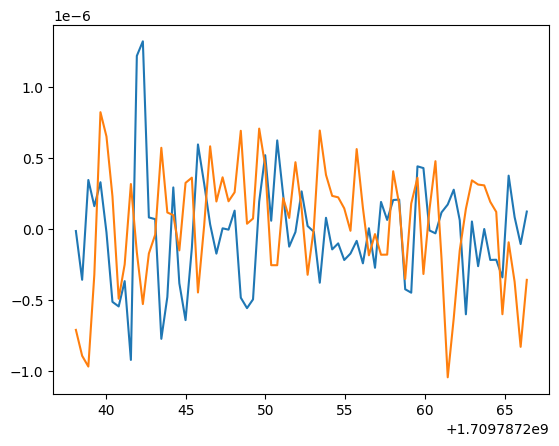

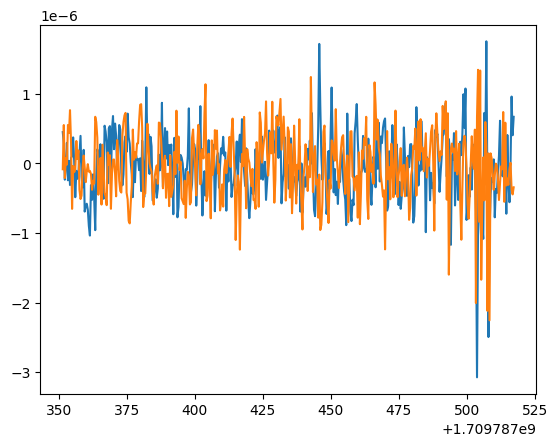

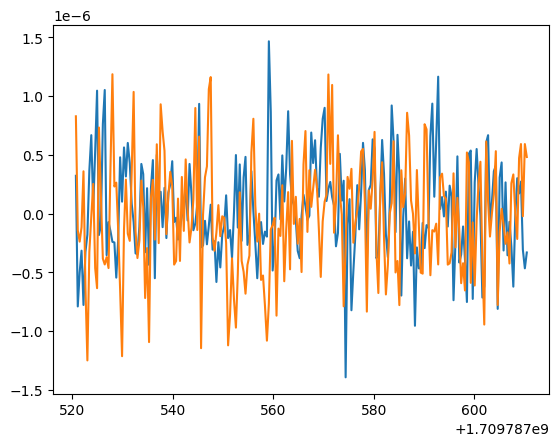

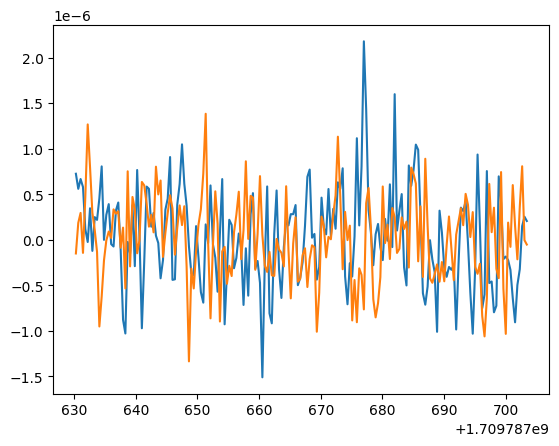

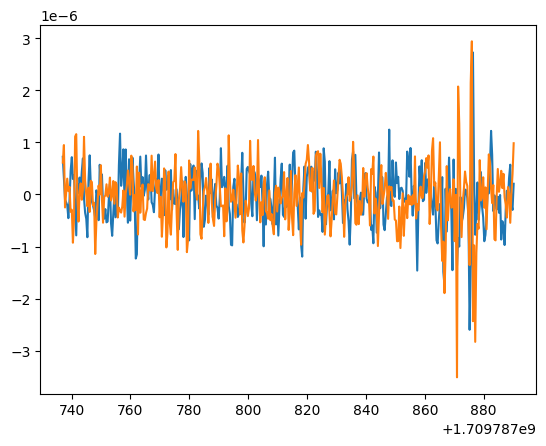

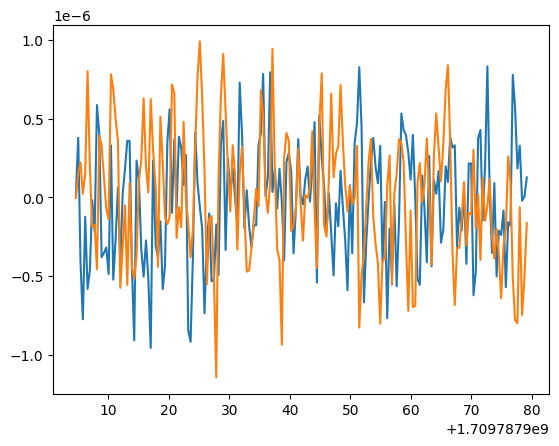

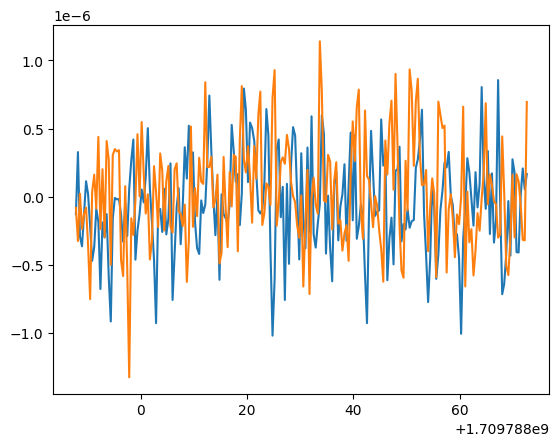

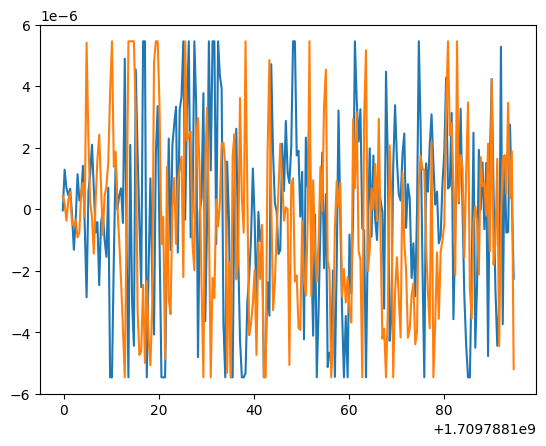

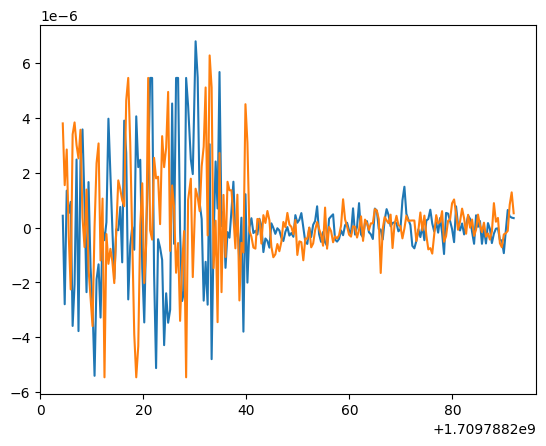

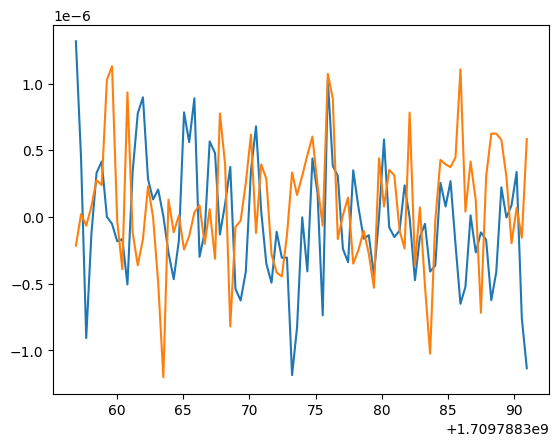

In [25]:
for i in [13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]:
    df = loader(i)
    plt.plot(df['curr_time'], df['lia1_X'])
    plt.plot(df['curr_time'], df['lia1_Y'])
    plt.show()